In [1]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
from urllib.parse import quote

import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.alert import Alert

from datetime import datetime, timedelta

import numpy as np
import statistics
from matplotlib import font_manager, rc 
import matplotlib.pyplot as plt
import matplotlib as mpl

#마이너스 표시
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

In [153]:
movie_df = pd.read_csv("./data/완_기간별_일별_170101_to_230509_ver1.csv")
movie_df.head()

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,배우,기준일,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수
0,1,너의 이름은.,2017-01-04 00:00:00,일본,일본,NaN,플러스엠 엔터테인먼트,12세이상관람가,"애니메이션,드라마,멜로/로맨스",신카이 마코토,"카미키 류노스케,카미시라이시 모네,나가사와 마사미,이치하라 에수코,유키 아오이,시마...",2017-01-08,2809088900,9745292442,333008,1182465,947,4101
1,3,모아나,2017-01-12 00:00:00,미국,미국,NaN,월트디즈니컴퍼니코리아 유한책임회사,전체관람가,애니메이션,"론 클레멘츠,존 머스커","드웨인 존슨,아우이 크라발호,알란 터딕,제메인 클레멘트,테무에라 모리슨",2017-01-08,7738000,9712000,910,1192,6,6
2,4,패신저스,2017-01-04 00:00:00,미국,미국,NaN,유니버설픽쳐스인터내셔널 코리아(유),12세이상관람가,"어드벤처,SF",모튼 틸덤,"크리스 프랫,제니퍼 로렌스,마이클 쉰,앤디 가르시아,로렌스 피쉬번",2017-01-08,1107502600,4176443418,129810,504393,608,2272
3,5,얼라이드,2017-01-11 00:00:00,미국,미국,NaN,롯데쇼핑㈜롯데엔터테인먼트,15세이상관람가,"스릴러,드라마,멜로/로맨스",로버트 저메키스,"브래드 피트,마리옹 꼬띠아르,리지 캐플란,매튜 구드,자레드 해리스",2017-01-08,0,32151000,0,3730,0,0
4,6,어쌔신 크리드,2017-01-11 00:00:00,미국,"미국,영국,프랑스",NaN,이십세기폭스코리아(주),15세이상관람가,"액션,어드벤처,판타지,SF",저스틴 커젤,"마이클 패스벤더,마리옹 꼬띠아르,아리안 라베드,제레미 아이언스,브렌단 글리슨,마이클...",2017-01-08,0,8289000,0,790,0,0


In [3]:
# 결측값 수 확인
movie_df.isnull().sum()

순위            0
영화명           0
개봉일           0
대표국적          0
국적            0
제작사      225295
배급사         224
등급           14
장르          574
감독        24563
배우        78099
기준일           0
매출액           0
누적매출액         0
관객수           0
누적관객수         0
스크린수          0
상영횟수          0
dtype: int64

In [117]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363272 entries, 0 to 363271
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   순위      363272 non-null  int64 
 1   영화명     363272 non-null  object
 2   개봉일     363272 non-null  object
 3   대표국적    363272 non-null  object
 4   국적      363272 non-null  object
 5   제작사     137977 non-null  object
 6   배급사     363048 non-null  object
 7   등급      363258 non-null  object
 8   장르      362698 non-null  object
 9   감독      338709 non-null  object
 10  배우      285173 non-null  object
 11  기준일     363272 non-null  object
 12  매출액     363272 non-null  int64 
 13  누적매출액   363272 non-null  int64 
 14  관객수     363272 non-null  int64 
 15  누적관객수   363272 non-null  int64 
 16  스크린수    363272 non-null  int64 
 17  상영횟수    363272 non-null  int64 
dtypes: int64(7), object(11)
memory usage: 49.9+ MB


In [154]:
# 개봉일과 기준일 날짜형식으로 바꾸기
movie_df['개봉일'] = pd.to_datetime(movie_df['개봉일'])
movie_df['기준일'] = pd.to_datetime(movie_df['기준일'])
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363272 entries, 0 to 363271
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   순위      363272 non-null  int64         
 1   영화명     363272 non-null  object        
 2   개봉일     363272 non-null  datetime64[ns]
 3   대표국적    363272 non-null  object        
 4   국적      363272 non-null  object        
 5   제작사     137977 non-null  object        
 6   배급사     363048 non-null  object        
 7   등급      363258 non-null  object        
 8   장르      362698 non-null  object        
 9   감독      338709 non-null  object        
 10  배우      285173 non-null  object        
 11  기준일     363272 non-null  datetime64[ns]
 12  매출액     363272 non-null  int64         
 13  누적매출액   363272 non-null  int64         
 14  관객수     363272 non-null  int64         
 15  누적관객수   363272 non-null  int64         
 16  스크린수    363272 non-null  int64         
 17  상영횟수    363272 non-null  int6

In [155]:
movie_df['기준연도'] = movie_df['기준일'].apply(lambda x : x.year)
movie_df['기준월'] = movie_df['기준일'].apply(lambda x : x.month)
movie_df['개봉연도'] = movie_df['개봉일'].apply(lambda x : x.year)
movie_df['개봉월'] = movie_df['개봉일'].apply(lambda x : x.month)
movie_df.head(1)

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,...,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
0,1,너의 이름은.,2017-01-04,일본,일본,NaN,플러스엠 엔터테인먼트,12세이상관람가,"애니메이션,드라마,멜로/로맨스",신카이 마코토,...,2809088900,9745292442,333008,1182465,947,4101,2017,1,2017,1


In [ ]:
# 매출액, 관객수, 스크린수, 상영횟수 모두가 0인 행 제외

In [157]:
movie_df = movie_df[(movie_df['매출액']!=0)&(movie_df['관객수']!=0)&
                   (movie_df['스크린수']!=0)&(movie_df['상영횟수']!=0)]

In [158]:
len(movie_df)

183006

# 연도별 총 매출 시각화 (2017~2022)

In [170]:
movie_df['기준일'].value_counts().to_frame()

,기준일
2019-11-08,121
2017-12-01,119
2020-11-28,119
2020-11-24,118
2019-11-19,117
...,...
2017-01-02,14
2017-01-03,14
2017-01-07,12
2017-01-08,11


In [164]:
movie_df['기준일'].max()

Timestamp('2023-05-06 00:00:00')

In [174]:
movie_df_info = movie_df[['영화명','개봉연도','개봉월','기준연도','기준월','매출액','관객수']]
movie_df_info

,영화명,개봉연도,개봉월,기준연도,기준월,매출액,관객수
0,너의 이름은.,2017,1,2017,1,2809088900,333008
1,모아나,2017,1,2017,1,7738000,910
2,패신저스,2017,1,2017,1,1107502600,129810
5,눈의 여왕 3: 눈과 불의 마법대결,2017,1,2017,1,535436000,67605
6,사랑하기 때문에,2017,1,2017,1,450612400,53856
...,...,...,...,...,...,...,...
363229,돈 지오반니,2017,1,2017,1,4881000,209
363230,걱정말아요,2017,1,2017,1,502000,71
363244,비밀객잔의 결투,2017,1,2017,1,7000,2
363245,소림사 무림 탐정-취의전장,2017,1,2017,1,7000,2


In [165]:
## 5월 영화 제외

In [182]:
month_sum = movie_df_info.groupby(["기준연도","기준월"])['매출액'].agg(['sum'])
month_sum.columns = ['총매출']
month_sum

총매출
기준연도 기준월              
2017 1    149844517327
     2    119222010654
     3    110757411220
     4     89172406575
     5    148934911530
...                ...
2023 1    123808074711
     2     62335465454
     3     79804374946
     4     69957651381
     5     34446431119

[77 rows x 1 columns]

In [183]:
month_sum.reset_index(inplace=True)
month_sum

,기준연도,기준월,총매출
0,2017,1,149844517327
1,2017,2,119222010654
2,2017,3,110757411220
3,2017,4,89172406575
4,2017,5,148934911530
...,...,...,...
72,2023,1,123808074711
73,2023,2,62335465454
74,2023,3,79804374946
75,2023,4,69957651381


In [184]:
month_sum_2017 = month_sum[month_sum['기준연도']==2017]
month_sum_2018 = month_sum[month_sum['기준연도']==2018]
month_sum_2019 = month_sum[month_sum['기준연도']==2019]
month_sum_2020 = month_sum[month_sum['기준연도']==2020]
month_sum_2021 = month_sum[month_sum['기준연도']==2021]
month_sum_2022 = month_sum[month_sum['기준연도']==2022]
month_sum_2023 = month_sum[month_sum['기준연도']==2023]

In [185]:
month_sum_2017

,기준연도,기준월,총매출
0,2017,1,149844517327
1,2017,2,119222010654
2,2017,3,110757411220
3,2017,4,89172406575
4,2017,5,148934911530
5,2017,6,120486520438
6,2017,7,167282584065
7,2017,8,233519041096
8,2017,9,100963016463
9,2017,10,174430622831


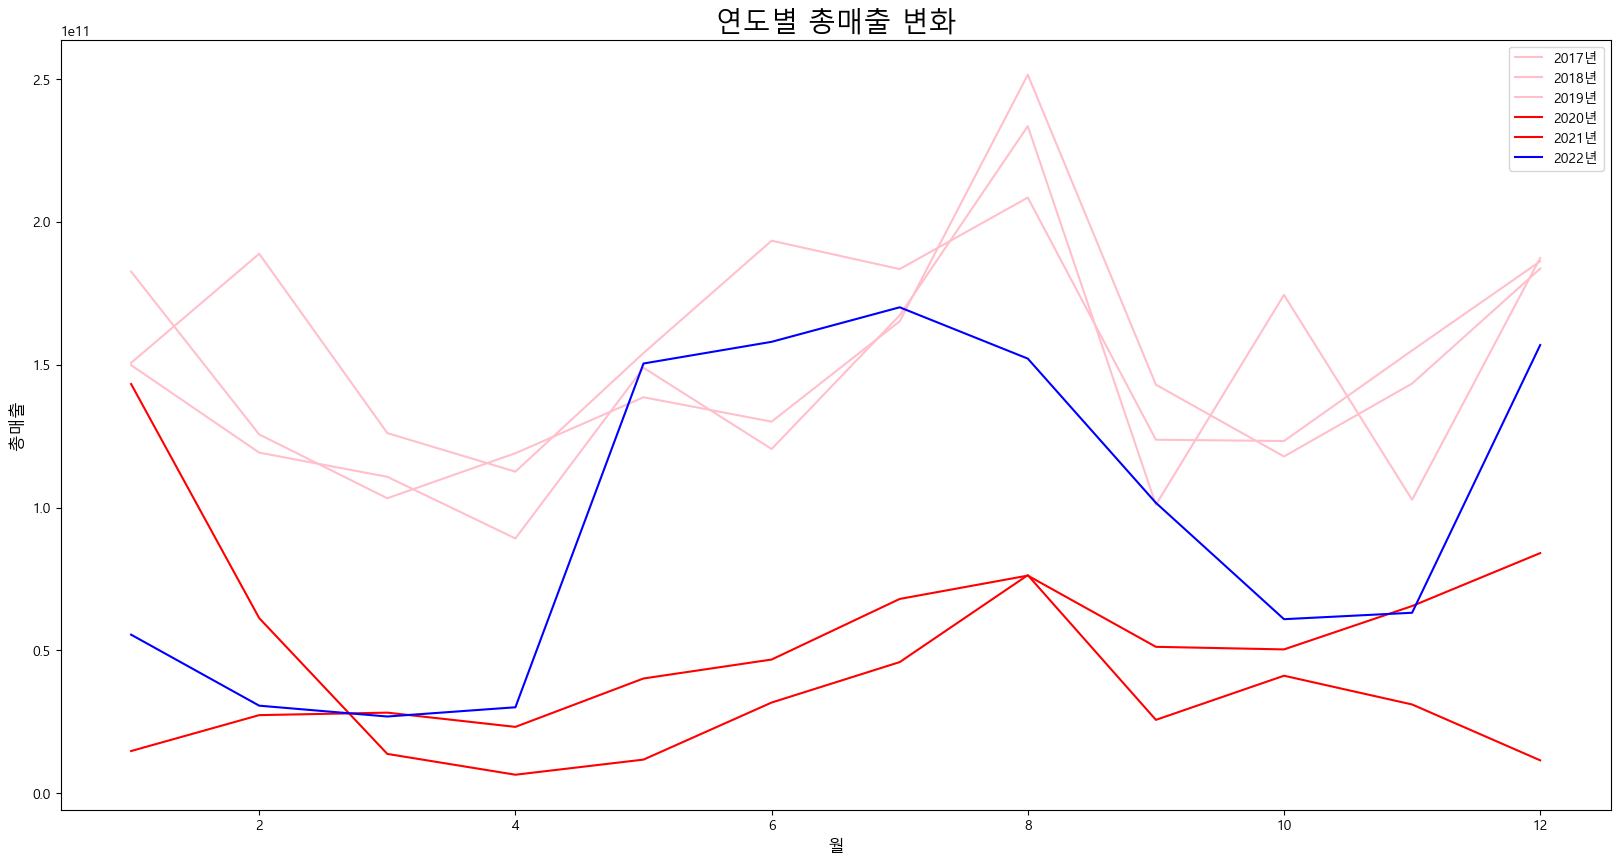

In [186]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(month_sum_2017['기준월'],month_sum_2017['총매출'], color="pink", label="2017년")
ax.plot(month_sum_2018['기준월'],month_sum_2018['총매출'], color="pink", label="2018년")
ax.plot(month_sum_2019['기준월'],month_sum_2019['총매출'], color="pink", label="2019년")
ax.plot(month_sum_2020['기준월'],month_sum_2020['총매출'], color="red", label="2020년")
ax.plot(month_sum_2021['기준월'],month_sum_2021['총매출'], color="red", label="2021년")
ax.plot(month_sum_2022['기준월'],month_sum_2022['총매출'], color="blue", label="2022년")

ax.legend(loc="best")
ax.set_title('연도별 총매출 변화', size=20)
ax.set_xlabel('월',size=12)
ax.set_ylabel('총매출',size=12)
plt.show()

In [191]:
year_sum = movie_df_info.groupby(["기준연도"])['매출액'].agg(['count','sum'])
year_sum

,count,sum
기준연도,,
2017,26289,1704688087463
2018,29564,1803723964724
2019,29395,1905789216740
2020,29356,499808908001
2021,29626,575737892070
2022,28441,1156311591025
2023,10335,370351997611


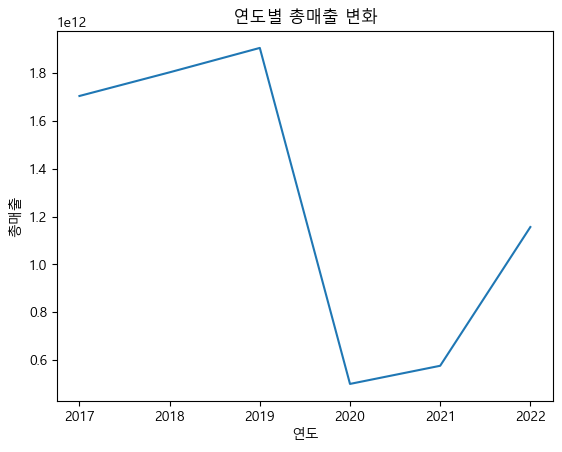

In [192]:
plt.plot(year_sum['sum'][:-1].index, year_sum['sum'][:-1])
plt.title("연도별 총매출 변화")
plt.xlabel('연도')
plt.ylabel('총매출')
plt.show()

## 관객수

In [193]:
movie_df_info

,영화명,개봉연도,개봉월,기준연도,기준월,매출액,관객수
0,너의 이름은.,2017,1,2017,1,2809088900,333008
1,모아나,2017,1,2017,1,7738000,910
2,패신저스,2017,1,2017,1,1107502600,129810
5,눈의 여왕 3: 눈과 불의 마법대결,2017,1,2017,1,535436000,67605
6,사랑하기 때문에,2017,1,2017,1,450612400,53856
...,...,...,...,...,...,...,...
363229,돈 지오반니,2017,1,2017,1,4881000,209
363230,걱정말아요,2017,1,2017,1,502000,71
363244,비밀객잔의 결투,2017,1,2017,1,7000,2
363245,소림사 무림 탐정-취의전장,2017,1,2017,1,7000,2


In [218]:
movie_df_info[movie_df_info['개봉연도']>movie_df_info['기준연도']]

,영화명,개봉연도,개봉월,기준연도,기준월,매출액,관객수
734,삼인행: 생존 게임,2018,3,2017,3,6000,1
864,슬랙 베이: 바닷가 마을의 비밀,2018,4,2017,3,52000,11
1250,삼인행: 생존 게임,2018,3,2017,3,68000,12
1372,나는보리,2020,5,2018,12,410000,62
1381,밤의 문이 열린다,2019,8,2018,12,572400,86
...,...,...,...,...,...,...,...
343986,스위치,2023,1,2022,12,106467884,10579
343988,더 퍼스트 슬램덩크,2023,1,2022,12,160000,16
344010,3000년의 기다림,2023,1,2022,12,5252500,309
344019,캐리와 슈퍼콜라,2023,1,2022,12,3993000,295


In [194]:
movie_df_info_people = movie_df_info.groupby(['기준연도','기준월'])['관객수'].sum().to_frame()
movie_df_info_people.reset_index(inplace=True)
movie_df_info_people

,기준연도,기준월,관객수
0,2017,1,18466312
1,2017,2,14910621
2,2017,3,13597595
3,2017,4,11038818
4,2017,5,18574231
...,...,...,...
72,2023,1,11220380
73,2023,2,5942445
74,2023,3,7445640
75,2023,4,6902721


In [195]:
movie_df_info_people[movie_df_info_people['기준연도']==2017]

,기준연도,기준월,관객수
0,2017,1,18466312
1,2017,2,14910621
2,2017,3,13597595
3,2017,4,11038818
4,2017,5,18574231
5,2017,6,14967939
6,2017,7,21116205
7,2017,8,29799218
8,2017,9,12625404
9,2017,10,21512294


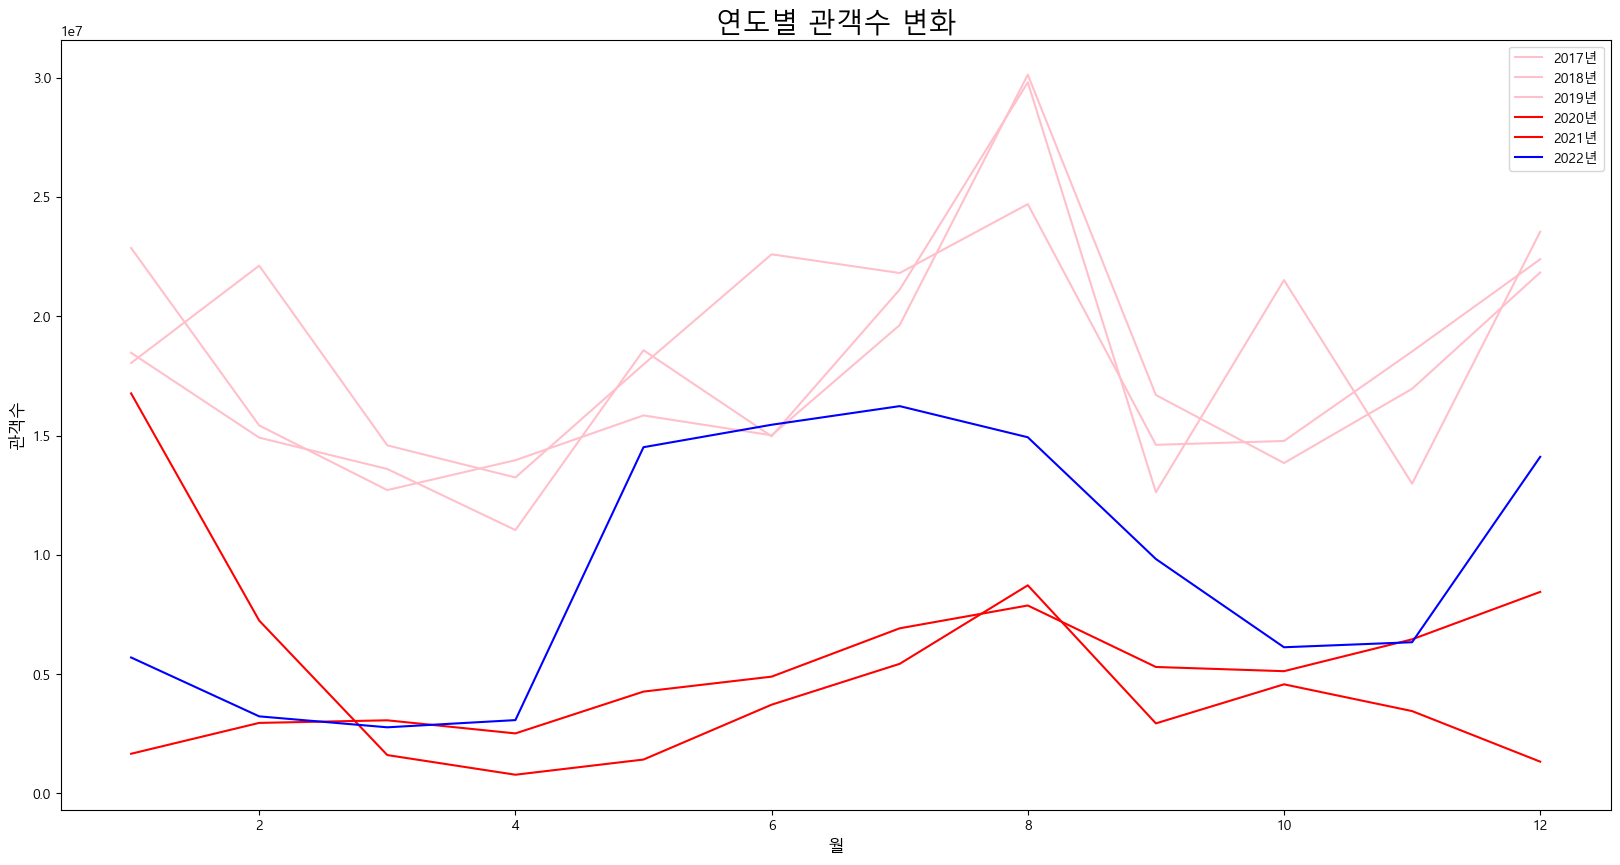

In [196]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(movie_df_info_people[movie_df_info_people['기준연도']==2017]['기준월'],movie_df_info_people[movie_df_info_people['기준연도']==2017]['관객수'], color="pink", label="2017년")
ax.plot(movie_df_info_people[movie_df_info_people['기준연도']==2018]['기준월'],movie_df_info_people[movie_df_info_people['기준연도']==2018]['관객수'], color="pink", label="2018년")
ax.plot(movie_df_info_people[movie_df_info_people['기준연도']==2019]['기준월'],movie_df_info_people[movie_df_info_people['기준연도']==2019]['관객수'], color="pink", label="2019년")
ax.plot(movie_df_info_people[movie_df_info_people['기준연도']==2020]['기준월'],movie_df_info_people[movie_df_info_people['기준연도']==2020]['관객수'], color="red", label="2020년")
ax.plot(movie_df_info_people[movie_df_info_people['기준연도']==2021]['기준월'],movie_df_info_people[movie_df_info_people['기준연도']==2021]['관객수'], color="red", label="2021년")
ax.plot(movie_df_info_people[movie_df_info_people['기준연도']==2022]['기준월'],movie_df_info_people[movie_df_info_people['기준연도']==2022]['관객수'], color="blue", label="2022년")

ax.legend(loc="best")
ax.set_title('연도별 관객수 변화', size=20)
ax.set_xlabel('월',size=12)
ax.set_ylabel('관객수',size=12)
plt.show()

## 영화수

In [205]:
movie_df_info_count = movie_df[['영화명','개봉연도','개봉월']]
movie_df_info_count.drop_duplicates(inplace=True)

print(len(movie_df_info)) 
print(len(movie_df_info_count))

183006
11626


C:\Users\tjoeun\AppData\Local\Temp\ipykernel_9048\2461366199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_info_count.drop_duplicates(inplace=True)


In [206]:
movie_df_info_count.head()

,영화명,개봉연도,개봉월
0,너의 이름은.,2017,1
1,모아나,2017,1
2,패신저스,2017,1
5,눈의 여왕 3: 눈과 불의 마법대결,2017,1
6,사랑하기 때문에,2017,1


In [208]:
movie_count_year = movie_df_info_count.groupby(['개봉연도'])['영화명'].count().to_frame()
movie_count_year 

,영화명
개봉연도,
2017,1763
2018,1867
2019,1947
2020,1899
2021,1858
2022,1773
2023,519


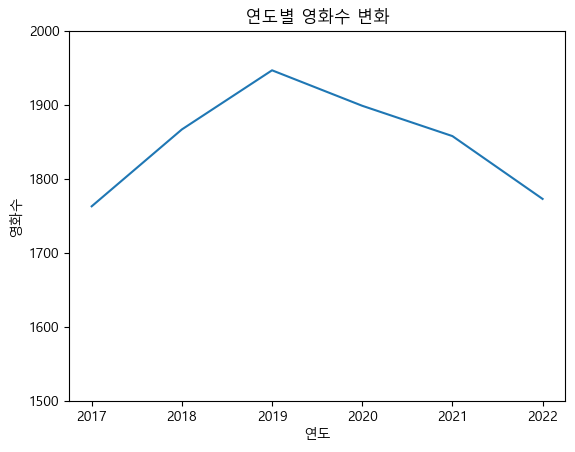

In [211]:
plt.plot(movie_count_year['영화명'][:-1].index, movie_count_year['영화명'][:-1])
plt.title("연도별 영화수 변화")
plt.xlabel('연도')
plt.ylabel('영화수')
plt.ylim(1500,2000)
plt.show()

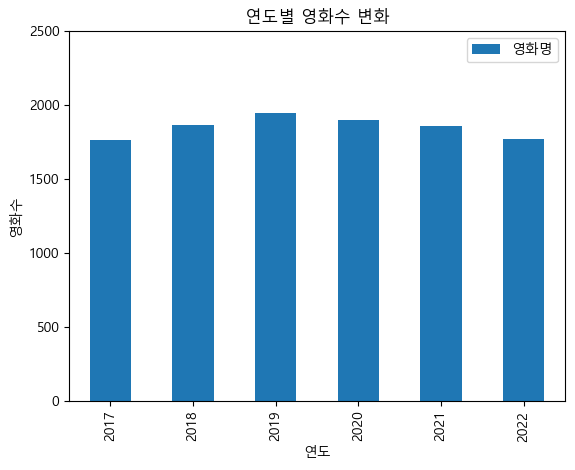

In [215]:
movie_count_year[['영화명']][:-1].plot(kind='bar')
plt.title("연도별 영화수 변화")
plt.xlabel('연도')
plt.ylabel('영화수')
plt.ylim(0,2500)
plt.show()

# 등급별 총매출

In [ ]:
movie_df

In [138]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183006 entries, 0 to 363246
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   순위      183006 non-null  int64         
 1   영화명     183006 non-null  object        
 2   개봉일     183006 non-null  datetime64[ns]
 3   대표국적    183006 non-null  object        
 4   국적      183006 non-null  object        
 5   제작사     66060 non-null   object        
 6   배급사     182938 non-null  object        
 7   등급      183004 non-null  object        
 8   장르      182901 non-null  object        
 9   감독      172295 non-null  object        
 10  배우      157239 non-null  object        
 11  기준일     183006 non-null  datetime64[ns]
 12  매출액     183006 non-null  int64         
 13  누적매출액   183006 non-null  int64         
 14  관객수     183006 non-null  int64         
 15  누적관객수   183006 non-null  int64         
 16  스크린수    183006 non-null  int64         
 17  상영횟수    183006 non-null  int6

In [139]:
len(movie_df)

array(['12세이상관람가', '전체관람가', '청소년관람불가', '15세이상관람가', '15세관람가', nan,
       '12세이상관람가,15세이상관람가', '연소자관람불가,청소년관람불가', '12세관람가'], dtype=object)

In [140]:
len(movie_df[movie_df['등급']=='12세이상관람가,15세이상관람가'])
movie_df[movie_df['등급']=='12세이상관람가,15세이상관람가']["영화명"].unique()

array(['라이크 크레이지'], dtype=object)

In [141]:
len(movie_df[movie_df['등급']=='연소자관람불가,청소년관람불가'])
movie_df[movie_df['등급']=='연소자관람불가,청소년관람불가']["영화명"].unique()

array(['죽어도 좋은 경험: 천사여 악녀가 되라'], dtype=object)

In [142]:
len(movie_df[movie_df['등급']=='12세관람가'])
movie_df[movie_df['등급']=='12세관람가']["영화명"].unique()

array(['던전 앤 드래곤: 도적들의 명예'], dtype=object)

In [143]:
movie_df['등급']=='12세이상관람가,15세이상관람가'

0         False
1         False
2         False
5         False
6         False
          ...  
363229    False
363230    False
363244    False
363245    False
363246    False
Name: 등급, Length: 183006, dtype: bool

In [144]:
movie_df['등급'].replace(['15세관람가', '12세이상관람가,15세이상관람가', '연소자관람불가,청소년관람불가', '12세관람가'],['15세이상관람가', '12세이상관람가', '청소년관람불가', '12세이상관람가'], inplace=True)
movie_df['등급'].unique()

array(['12세이상관람가', '전체관람가', '청소년관람불가', '15세이상관람가', nan], dtype=object)

In [145]:
movie_df[movie_df['등급'].isnull()==True]

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,배우,기준일,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월
48706,184,좀비 vs 헌터,2018-01-11,캐나다,캐나다,NaN,(주)고맙습니다 사랑합니다,NaN,"액션,스릴러,코미디,SF",K. 킹,"마틴 코핑,대니 트레조",2018-01-11,2000,2000,1,1,1,1,2018,1
208267,232,임파서블 미션,2020-09-23,스페인,스페인,NaN,(주)박수엔터테인먼트,NaN,액션,NaN,NaN,2020-09-23,5000,5000,1,1,1,1,2020,9


In [146]:
grade_df = movie_df[movie_df['등급'].isnull()==False]
grade_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183004 entries, 0 to 363246
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   순위      183004 non-null  int64         
 1   영화명     183004 non-null  object        
 2   개봉일     183004 non-null  datetime64[ns]
 3   대표국적    183004 non-null  object        
 4   국적      183004 non-null  object        
 5   제작사     66060 non-null   object        
 6   배급사     182936 non-null  object        
 7   등급      183004 non-null  object        
 8   장르      182899 non-null  object        
 9   감독      172294 non-null  object        
 10  배우      157238 non-null  object        
 11  기준일     183004 non-null  datetime64[ns]
 12  매출액     183004 non-null  int64         
 13  누적매출액   183004 non-null  int64         
 14  관객수     183004 non-null  int64         
 15  누적관객수   183004 non-null  int64         
 16  스크린수    183004 non-null  int64         
 17  상영횟수    183004 non-null  int6

In [147]:
grade_df_기준연도 = grade_df.groupby(['기준연도','등급'])['매출액'].agg(['count','sum','mean'])
grade_df_기준연도

count           sum          mean
기준연도 등급                                         
2017 12세이상관람가  10035  596726504936  5.946452e+07
     15세이상관람가  11517  843361256716  7.322751e+07
     전체관람가      6722  180663840925  2.687650e+07
     청소년관람불가    4818  192958713391  4.004955e+07
2018 12세이상관람가   8636  963239446016  1.115377e+08
     15세이상관람가  12074  536405322993  4.442648e+07
     전체관람가      6977  150242584844  2.153398e+07
     청소년관람불가    3265   86316203210  2.643682e+07
2019 12세이상관람가   9240  725811189384  7.855099e+07
     15세이상관람가  11220  696404560203  6.206814e+07
     전체관람가      7759  432518225261  5.574407e+07
     청소년관람불가    3519   71121698509  2.021077e+07
2020 12세이상관람가   7365  128984615248  1.751319e+07
     15세이상관람가   9305  252386876617  2.712379e+07
     전체관람가      6876   48324178833  7.027949e+06
     청소년관람불가    3373   16020989190  4.749774e+06
2021 12세이상관람가   9860  303387863146  3.076956e+07
     15세이상관람가   9303  193839010255  2.083618e+07
     전체관람가      5187   63724036181  1.228534e+07
     청소년관람불가    2949   38215051010  1.295865e+07
2022 12세이상관람가   8805  681479648809  7.739689e+07
     15세이상관람가   9632  416544714644  4.324592e+07
     전체관람가      5727   91242647740  1.593201e+07
     청소년관람불가    2444   10815445717  4.425305e+06
2023 12세이상관람가   2033  187298305361  9.212902e+07
     15세이상관람가   2248   42970267144  1.911489e+07
     전체관람가      1401   43838338756  3.129075e+07
     청소년관람불가     714   21570115595  3.021025e+07

In [148]:
grade_df_기준연도 = grade_df.groupby(['등급','기준연도'])['매출액'].agg(['count','sum','mean'])
grade_df_기준연도

count           sum          mean
등급       기준연도                                   
12세이상관람가 2017  10035  596726504936  5.946452e+07
         2018   8636  963239446016  1.115377e+08
         2019   9240  725811189384  7.855099e+07
         2020   7365  128984615248  1.751319e+07
         2021   9860  303387863146  3.076956e+07
         2022   8805  681479648809  7.739689e+07
         2023   2033  187298305361  9.212902e+07
15세이상관람가 2017  11517  843361256716  7.322751e+07
         2018  12074  536405322993  4.442648e+07
         2019  11220  696404560203  6.206814e+07
         2020   9305  252386876617  2.712379e+07
         2021   9303  193839010255  2.083618e+07
         2022   9632  416544714644  4.324592e+07
         2023   2248   42970267144  1.911489e+07
전체관람가    2017   6722  180663840925  2.687650e+07
         2018   6977  150242584844  2.153398e+07
         2019   7759  432518225261  5.574407e+07
         2020   6876   48324178833  7.027949e+06
         2021   5187   63724036181  1.228534e+07
         2022   5727   91242647740  1.593201e+07
         2023   1401   43838338756  3.129075e+07
청소년관람불가  2017   4818  192958713391  4.004955e+07
         2018   3265   86316203210  2.643682e+07
         2019   3519   71121698509  2.021077e+07
         2020   3373   16020989190  4.749774e+06
         2021   2949   38215051010  1.295865e+07
         2022   2444   10815445717  4.425305e+06
         2023    714   21570115595  3.021025e+07

In [149]:
grade_df_기준연도.columns=["영화수","총매출합계","총매출평균"]
grade_df_기준연도.reset_index(inplace=True)
grade_df_기준연도.head()

,등급,기준연도,영화수,총매출합계,총매출평균
0,12세이상관람가,2017,10035,596726504936,5.946452e+07
1,12세이상관람가,2018,8636,963239446016,1.115377e+08
2,12세이상관람가,2019,9240,725811189384,7.855099e+07
3,12세이상관람가,2020,7365,128984615248,1.751319e+07
4,12세이상관람가,2021,9860,303387863146,3.076956e+07


In [150]:
grade_df_기준연도['총매출합계'] = round(grade_df_기준연도['총매출합계']/1000000,1)
grade_df_기준연도['총매출평균'] = round(grade_df_기준연도['총매출평균']/1000000,1)
grade_df_기준연도.head()

,등급,기준연도,영화수,총매출합계,총매출평균
0,12세이상관람가,2017,10035,596726.5,59.5
1,12세이상관람가,2018,8636,963239.4,111.5
2,12세이상관람가,2019,9240,725811.2,78.6
3,12세이상관람가,2020,7365,128984.6,17.5
4,12세이상관람가,2021,9860,303387.9,30.8


In [151]:
grade_df_기준연도

,등급,기준연도,영화수,총매출합계,총매출평균
0,12세이상관람가,2017,10035,596726.5,59.5
1,12세이상관람가,2018,8636,963239.4,111.5
2,12세이상관람가,2019,9240,725811.2,78.6
3,12세이상관람가,2020,7365,128984.6,17.5
4,12세이상관람가,2021,9860,303387.9,30.8
5,12세이상관람가,2022,8805,681479.6,77.4
6,12세이상관람가,2023,2033,187298.3,92.1
7,15세이상관람가,2017,11517,843361.3,73.2
8,15세이상관람가,2018,12074,536405.3,44.4
9,15세이상관람가,2019,11220,696404.6,62.1


In [152]:
grade_df.groupby(['등급'])['매출액'].agg(['count','sum','mean'])

,count,sum,mean
등급,,,
12세이상관람가,55974,3586927572900,6.408203e+07
15세이상관람가,65299,2981912008572,4.566551e+07
전체관람가,40649,1010553852540,2.486048e+07
청소년관람불가,21082,437018216622,2.072945e+07


# 역대 박스오피스

In [220]:
best_movie = pd.read_excel('./data/(완)역대_박스오피스(2023.05.11).xlsx')
best_movie

,순위,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사
0,1,명량,2014-07-30,135758658810,17615919,1587,188726,한국,한국,(주)씨제이이엔엠
1,2,극한직업,2019-01-23,139655543516,16266338,2003,292816,한국,한국,(주)씨제이이엔엠
2,3,신과함께-죄와 벌,2017-12-20,115727528087,14414658,1912,214631,한국,한국,롯데쇼핑㈜롯데엔터테인먼트
3,4,국제시장,2014-12-17,110947621230,14264478,1044,212705,한국,한국,(주)씨제이이엔엠
4,5,어벤져스: 엔드게임,2019-04-24,122492181020,13977602,2835,246433,미국,미국,월트디즈니컴퍼니코리아 유한책임회사
...,...,...,...,...,...,...,...,...,...,...
195,196,해리 포터와 불의 잔,2005-12-01,22097731900,3499257,504,45555,미국,미국,워너브러더스 코리아(주)
196,197,비긴 어게인,2014-08-13,27433947031,3479444,525,87565,미국,미국,판씨네마(주)
197,198,태풍,2005-12-14,22209675300,3471150,481,47155,한국,한국,CJ ENM
198,199,킹콩,2005-12-14,21476688172,3470059,319,38456,미국,미국,UIP코리아
